# Flower Recognition CNN Keras

## [ Please upvote / star if you like it ;)  ]

In [1]:
import os
print(os.listdir('/content/flowers'))

['rose', '.ipynb_checkpoints', 'gaenari', 'sakura']


## CONTENTS ::

[ **1 ) Importing Various Modules**](#content1)

[ **2 ) Preparing the Data**](#content2)

[ **3 ) Modelling**](#content3)

[ **4 ) Evaluating the Model Performance**](#content4)

[ **5 ) Visualizing Predictons on the Validation Set**](#content5)

<a id="content1"></a>
## 1 ) Importing Various Modules.

In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings
('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

# #model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

<a id="content2"></a>
## 2 ) Preparing the Data

## 2.1) Making the functions to get the training and validation set from the Images

In [3]:
X=[]
Z=[]
IMG_SIZE=150
# FLOWER_DAISY_DIR='../input/flowers/flowers/daisy'
# FLOWER_SUNFLOWER_DIR='../input/flowers/flowers/sunflower'
# FLOWER_TULIP_DIR='../input/flowers/flowers/tulip'
# FLOWER_DANDI_DIR='../input/flowers/flowers/dandelion'
FLOWER_GAENARI_DIR='/content/flowers/gaenari'
FLOWER_ROSE_DIR='../content/flowers/rose'
FLOWER_SAKURA_DIR='../content/flowers/sakura'

In [4]:
def assign_label(img,flower_type):
    return flower_type

In [5]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [6]:
# make_train_data('Daisy',FLOWER_DAISY_DIR)
# print(len(X))

In [ ]:
# make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
# print(len(X))

In [ ]:
# make_train_data('Tulip',FLOWER_TULIP_DIR)
# print(len(X))

In [ ]:
# make_train_data('Dandelion',FLOWER_DANDI_DIR)
# print(len(X))

In [7]:
make_train_data('Gaenari',FLOWER_GAENARI_DIR)
print(len(X))

100%|██████████| 297/297 [00:00<00:00, 625.88it/s]

297


In [8]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 272/272 [00:00<00:00, 743.95it/s]

569


In [9]:
make_train_data('Sakura',FLOWER_SAKURA_DIR)
print(len(X))

100%|██████████| 700/700 [00:08<00:00, 84.44it/s]

1269


## 2.2 ) Visualizing some Random Images

IndexError: list index out of range

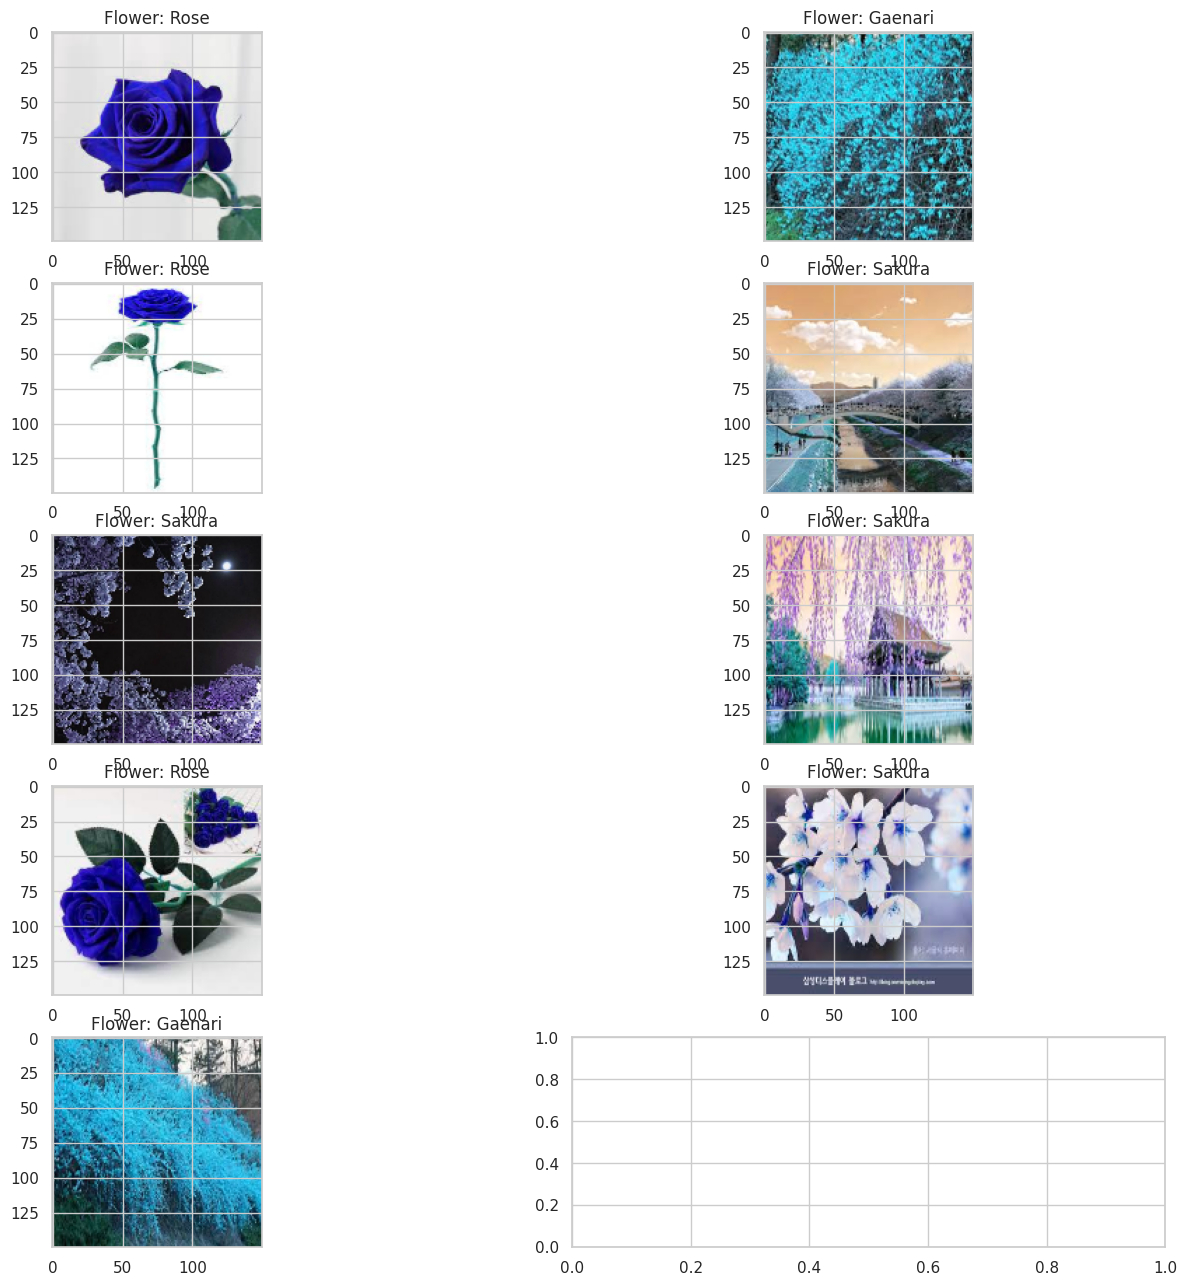

In [10]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])

plt.tight_layout()

## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [11]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,len(set(Z)))
X=np.array(X)
X=X/255

## 2.4 ) Splitting into Training and Validation Sets

In [12]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

## 2.5 ) Setting the Random Seeds

In [13]:
np.random.seed(42)
rn.seed(42)
# tf.set_random_seed(42)
tf.random.set_seed(42)

<a id="content3"></a>
## 3 ) Modelling

## 3.1 ) Building the ConvNet Model

In [14]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(3, activation = "softmax"))

## 3.2 ) Using a LR Annealer

In [15]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## 3.3 ) Data Augmentation to prevent Overfitting

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## 3.4 ) Compiling the Keras Model & Summary

In [17]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0

## 3.5 ) Fitting on the Training set and making predcitons on the Validation set

In [19]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
7/7 [==============================] - 16s 1s/step - loss: 1.0475 - accuracy: 0.6379 - val_loss: 0.6670 - val_accuracy: 0.9057
Epoch 2/50
7/7 [==============================] - 7s 950ms/step - loss: 0.3928 - accuracy: 0.8991 - val_loss: 0.1908 - val_accuracy: 0.9277
Epoch 3/50
7/7 [==============================] - 6s 774ms/step - loss: 0.1678 - accuracy: 0.9502 - val_loss: 0.2546 - val_accuracy: 0.9497
Epoch 4/50
7/7 [==============================] - 7s 919ms/step - loss: 0.2062 - accuracy: 0.9526 - val_loss: 0.1265 - val_accuracy: 0.9686
Epoch 5/50
7/7 [==============================] - 7s 982ms/step - loss: 0.1113 - accuracy: 0.9648 - val_loss: 0.0877 - val_accuracy: 0.9623
Epoch 6/50
7/7 [==============================] - 6s 799ms/step - loss: 0.1117 - accuracy: 0.9721 - val_loss: 0.0690 - val_accuracy: 0.9654
Epoch 7/50
7/7 [==============================] - 7s 962ms/step - loss: 0.1094 - accuracy: 0.9648 - val_loss: 0.0638 - val_accuracy: 0.9717
Epoch 8/50
7/7 [======

<a id="content4"></a>
## 4 ) Evaluating the Model Performance

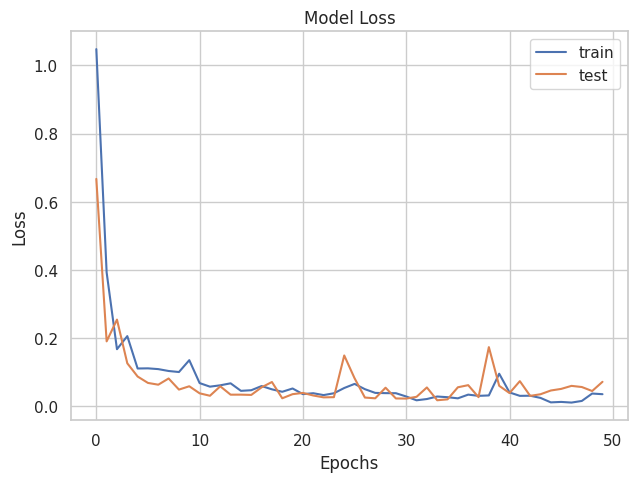

In [20]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

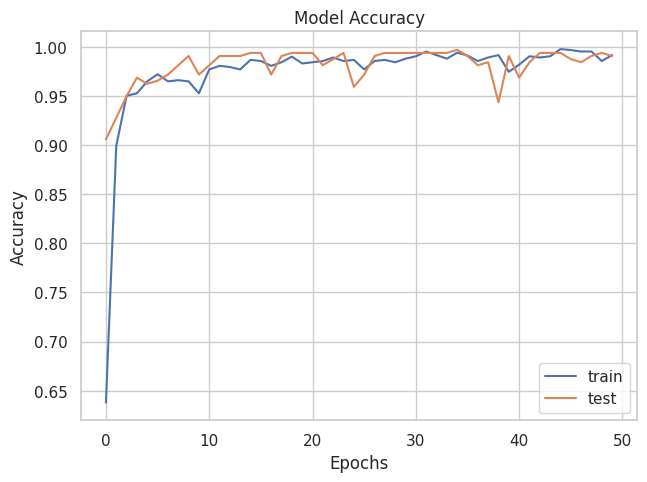

In [21]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


<a id="content5"></a>
## 5 ) Visualizing Predictions on the Validation Set

In [22]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

10/10 [==============================] - 0s 12ms/step


In [23]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

#### CORRECTLY CLASSIFIED FLOWER IMAGES

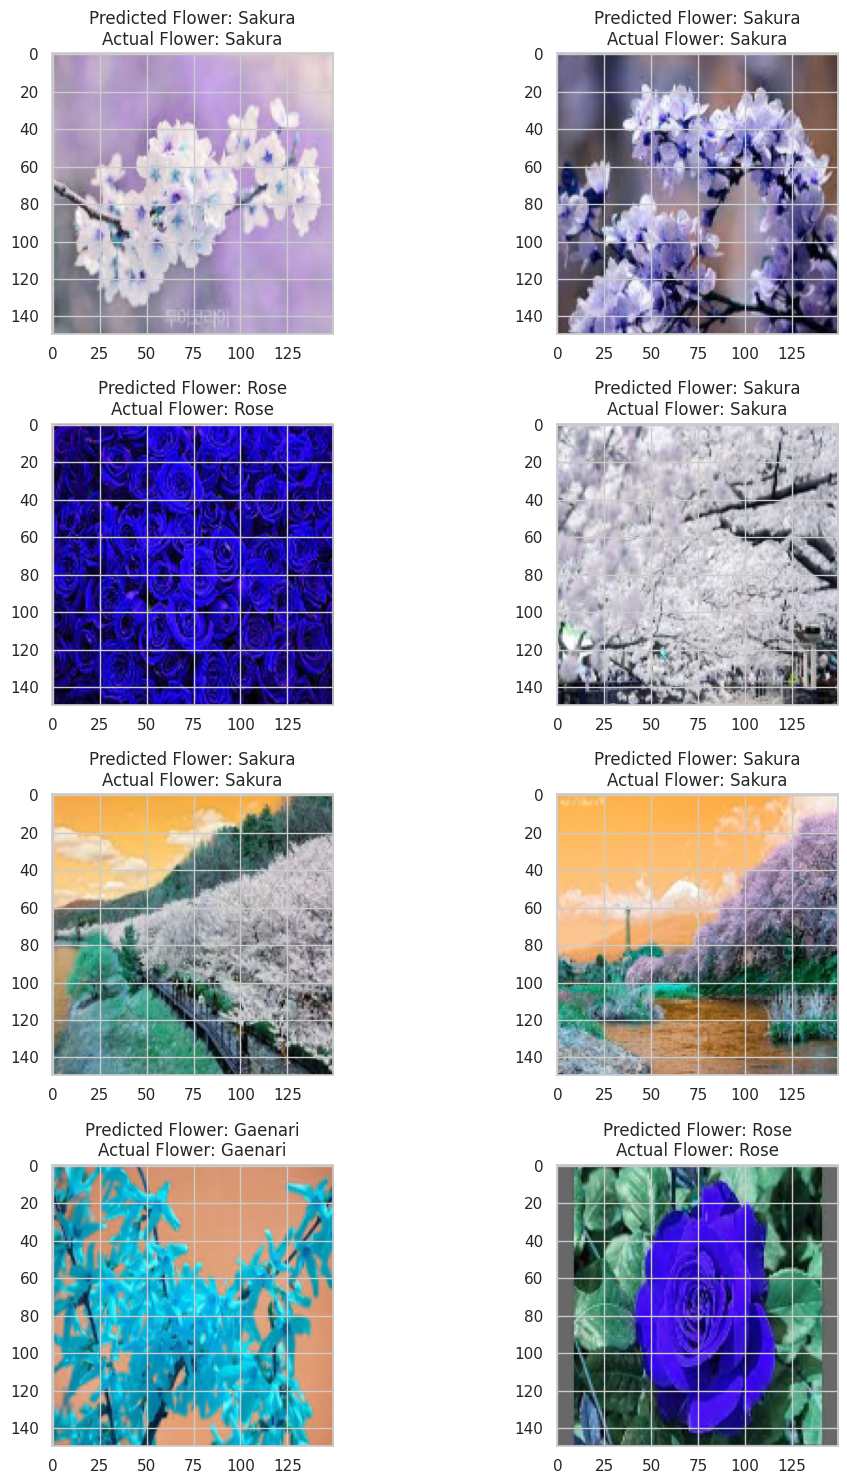

In [29]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)
for i in range(4):
    for j in range(2):
        predicted_flower = le.inverse_transform([pred_digits[prop_class[count]]])[0]
        actual_flower = le.inverse_transform([np.argmax(y_test[prop_class[count]])])[0]
        ax[i, j].imshow(x_test[prop_class[count]])
        ax[i, j].set_title("Predicted Flower: " + str(predicted_flower) + "\n" + "Actual Flower: " + str(actual_flower))
        plt.tight_layout()
        count += 1

<a id="content5"></a>
## END

In [26]:
from keras.preprocessing import image
import numpy as np

# 이미지 업로드
uploaded_image_path = "/content/test/test1.jpg"  # 업로드한 이미지 파일 경로를 설정

# 이미지 불러오기 및 전처리
img = image.load_img(uploaded_image_path, target_size=(150, 150))  # 이미지를 읽고 크기를 조정
img_array = image.img_to_array(img)  # 이미지를 배열로 변환
img_array = np.expand_dims(img_array, axis=0)  # 이미지 차원을 추가
img_array /= 255.  # 이미지를 정규화

# 모델 예측
predictions = model.predict(img_array)

# 예측 결과 확인
class_names = ['gaenari', 'rose', 'sakura']  # 클래스 이름을 설정
predicted_class = np.argmax(predictions[0])  # 가장 높은 확률을 가진 클래스를 선택
predicted_class_name = class_names[predicted_class]  # 선택된 클래스의 이름

print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 319ms/step
Predicted class: sakura


In [28]:
import os
import pickle

# 파일이 저장될 디렉토리 경로 설정
save_dir = "/content/model/"

# 모델 아키텍처를 JSON 형식으로 저장하는 예시
model_json = model.to_json()
model_json_path = os.path.join(save_dir, "model.json")
with open(model_json_path, "w") as json_file:
    json_file.write(model_json)

# 모델 가중치를 H5 파일로 저장하는 예시
model_weights_path = os.path.join(save_dir, "model_weights.h5")
model.save_weights(model_weights_path)

# History를 저장하는 예시 (pickle을 사용하여 객체를 직렬화)
history_path = os.path.join(save_dir, "history.pkl")
with open(history_path, 'wb') as file:
    pickle.dump(History.history, file)